Device: cuda | Mixed precision: True


100%|██████████| 170M/170M [00:03<00:00, 48.2MB/s]


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] | num_classes: 10


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Split sizes -> train: 40000 | val: 10000 | test: 10000


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Total parameters: 85,806,346 | Trainable: 85,806,346
Starting training...


/tmp/ipython-input-2338443350.py:119: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=amp_enabled)
/tmp/ipython-input-2338443350.py:131: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=amp_enabled):


Epoch 01/40 | Train Loss 1.7470 Acc 53.88% | Val Loss 1.1102 Acc 87.54% | LR 0.000021
✓ Saved new best checkpoint -> deit_cifar10_best.ckpt
Epoch 02/40 | Train Loss 0.6379 Acc 94.99% | Val Loss 0.5567 Acc 97.96% | LR 0.000041
✓ Saved new best checkpoint -> deit_cifar10_best.ckpt
Epoch 03/40 | Train Loss 0.5871 Acc 96.50% | Val Loss 0.5465 Acc 98.36% | LR 0.000060
✓ Saved new best checkpoint -> deit_cifar10_best.ckpt
Epoch 04/40 | Train Loss 0.5774 Acc 96.74% | Val Loss 0.5537 Acc 97.65% | LR 0.000080
Epoch 05/40 | Train Loss 0.5771 Acc 96.77% | Val Loss 0.5645 Acc 97.38% | LR 0.000051
Epoch 06/40 | Train Loss 0.5481 Acc 98.00% | Val Loss 0.5497 Acc 98.09% | LR 0.000035
Epoch 07/40 | Train Loss 0.5316 Acc 98.69% | Val Loss 0.5422 Acc 98.29% | LR 0.000021
✓ Saved new best checkpoint -> deit_cifar10_best.ckpt
Epoch 08/40 | Train Loss 0.5205 Acc 99.16% | Val Loss 0.5371 Acc 98.46% | LR 0.000010
✓ Saved new best checkpoint -> deit_cifar10_best.ckpt
Epoch 09/40 | Train Loss 0.5179 Acc 99.29%

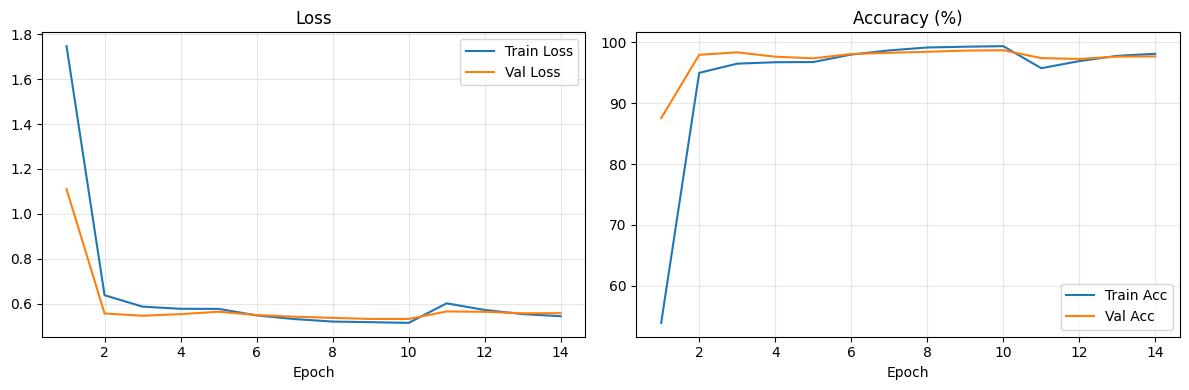


TEST | Loss 0.5633 | Acc 97.36%

Classification Report:
              precision    recall  f1-score   support

    airplane     0.9889    0.9800    0.9844      1000
  automobile     0.9781    0.9810    0.9795      1000
        bird     0.9928    0.9630    0.9777      1000
         cat     0.9296    0.9510    0.9402      1000
        deer     0.9750    0.9740    0.9745      1000
         dog     0.9313    0.9620    0.9464      1000
        frog     0.9813    0.9970    0.9891      1000
       horse     0.9979    0.9570    0.9770      1000
        ship     0.9861    0.9910    0.9885      1000
       truck     0.9790    0.9800    0.9795      1000

    accuracy                         0.9736     10000
   macro avg     0.9740    0.9736    0.9737     10000
weighted avg     0.9740    0.9736    0.9737     10000



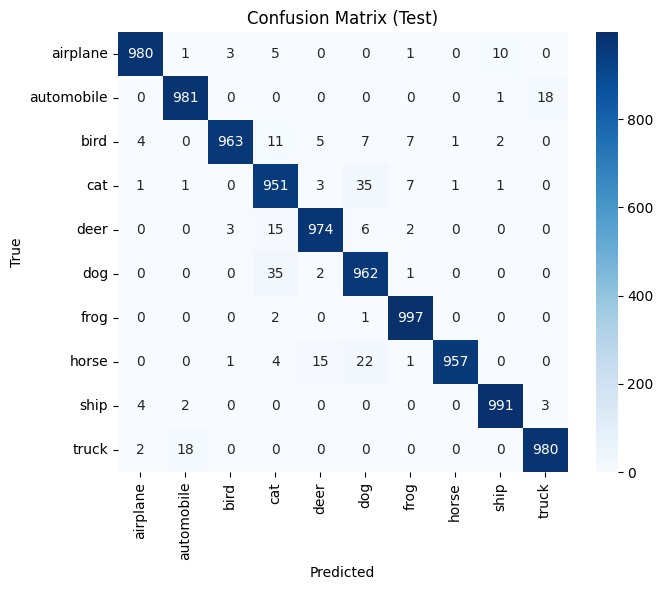


Saved for inference:
 - deit_cifar10_best.ckpt (training checkpoint with optimizer/scheduler)
 - deit_cifar10_inference_state.pth (model state dict for inference)
 - deit_cifar10_inference_meta.json (classes + preprocessing)


In [1]:
# ======type 3

#======================================================
# DeiT-Base (timm) on CIFAR-10 with Train/Val/Test
# - Stratified train/val split from CIFAR-10 train (e.g., 80/20)
# - Test set untouched for final evaluation
# - ImageNet normalization, AutoAugment, RandomErasing
# - Mixed precision (autocast + GradScaler)
# - Cosine LR schedule, early stopping
# - End-to-end fine-tuning from ImageNet-pretrained DeiT-Base
# - Saves best checkpoint + minimal inference bundle
# ============================================================

import os, json, random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import transforms, datasets

import timm
from timm.scheduler import CosineLRScheduler

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix

# -------------------- Reproducibility --------------------
SEED = 1337
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True  # speed; set False for fully deterministic

# -------------------- Device --------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
amp_enabled = torch.cuda.is_available()
print("Device:", device, "| Mixed precision:", amp_enabled)

# -------------------- Config --------------------
img_size   = 224
batch_size = 64
epochs     = 40
val_ratio  = 0.20
patience   = 5
num_workers = 4 if torch.cuda.is_available() else 2

# -------------------- Transforms --------------------
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    transforms.RandomErasing(p=0.2)
])

eval_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# -------------------- CIFAR-10 datasets --------------------
root = "./data"
full_train = datasets.CIFAR10(root=root, train=True, download=True, transform=train_transform)
test_ds    = datasets.CIFAR10(root=root, train=False, download=True, transform=eval_transform)

class_names = full_train.classes  # ['airplane', 'automobile', ...]
num_classes = len(class_names)
print("Classes:", class_names, "| num_classes:", num_classes)

# Collect labels for stratified split
targets = np.array(full_train.targets)

# Stratified train/val split on CIFAR-10 train set
sss = StratifiedShuffleSplit(n_splits=1, test_size=val_ratio, random_state=SEED)
train_idx, val_idx = next(sss.split(np.zeros(len(targets)), targets))

# Build two datasets with appropriate transforms
train_ds = datasets.CIFAR10(root=root, train=True, download=False, transform=train_transform)
val_ds   = datasets.CIFAR10(root=root, train=True, download=False, transform=eval_transform)

train_subset = Subset(train_ds, train_idx)
val_subset   = Subset(val_ds,   val_idx)

# -------------------- Loaders --------------------
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=True)
val_loader   = DataLoader(val_subset,   batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True)
test_loader  = DataLoader(test_ds,      batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True)

print(f"Split sizes -> train: {len(train_subset)} | val: {len(val_subset)} | test: {len(test_ds)}")

# -------------------- Model (end-to-end fine-tuning) --------------------
model = timm.create_model('deit_base_patch16_224', pretrained=True, num_classes=num_classes)
model = model.to(device)

# Count params
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,} | Trainable: {trainable_params:,}")

# -------------------- Optimizer / Loss / Scheduler --------------------
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

lr_scheduler = CosineLRScheduler(
    optimizer,
    t_initial=10,
    lr_min=1e-6,
    warmup_lr_init=1e-6,
    warmup_t=5,
    cycle_limit=5,
)

scaler = torch.cuda.amp.GradScaler(enabled=amp_enabled)

# -------------------- Train / Eval helpers --------------------
def run_epoch(loader, train_mode=True):
    model.train() if train_mode else model.eval()

    total_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []

    for imgs, labels in loader:
        imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        with torch.cuda.amp.autocast(enabled=amp_enabled):
            outputs = model(imgs)
            loss = criterion(outputs, labels)

        if train_mode:
            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        total_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total   += labels.size(0)

        all_preds.append(preds.detach().cpu().numpy())
        all_labels.append(labels.detach().cpu().numpy())

    avg_loss = total_loss / max(1, total)
    acc = 100.0 * correct / max(1, total)
    all_preds  = np.concatenate(all_preds) if all_preds else np.array([])
    all_labels = np.concatenate(all_labels) if all_labels else np.array([])

    return avg_loss, acc, all_preds, all_labels

# -------------------- Training loop with early stopping --------------------
best_val = float('inf')
best_state = None
best_epoch = -1
wait = 0

train_losses, val_losses, train_accs, val_accs, lrs = [], [], [], [], []

print("Starting training...")
for epoch in range(1, epochs+1):
    tr_loss, tr_acc, _, _ = run_epoch(train_loader, train_mode=True)

    lr_scheduler.step(epoch)
    current_lr = optimizer.param_groups[0]['lr']

    va_loss, va_acc, _, _ = run_epoch(val_loader, train_mode=False)

    train_losses.append(tr_loss); val_losses.append(va_loss)
    train_accs.append(tr_acc);    val_accs.append(va_acc)
    lrs.append(current_lr)

    print(f"Epoch {epoch:02d}/{epochs} | "
          f"Train Loss {tr_loss:.4f} Acc {tr_acc:.2f}% | "
          f"Val Loss {va_loss:.4f} Acc {va_acc:.2f}% | "
          f"LR {current_lr:.6f}")

    if va_loss < best_val - 1e-4:
        best_val = va_loss
        best_epoch = epoch
        wait = 0
        best_state = {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "scheduler_state_dict": lr_scheduler.state_dict(),
            "class_names": class_names,
            "img_size": img_size,
            "imagenet_mean": IMAGENET_MEAN,
            "imagenet_std": IMAGENET_STD,
        }
        torch.save(best_state, "deit_cifar10_best.ckpt")
        print("✓ Saved new best checkpoint -> deit_cifar10_best.ckpt")
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered. Restoring best weights from epoch", best_epoch)
            break

# Restore best model before testing
if best_state is not None:
    model.load_state_dict(best_state["model_state_dict"])

# -------------------- Plots --------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
epochs_range = range(1, len(train_losses)+1)
ax1.plot(epochs_range, train_losses, label="Train Loss")
ax1.plot(epochs_range, val_losses,   label="Val Loss")
ax1.set_title("Loss"); ax1.set_xlabel("Epoch"); ax1.legend(); ax1.grid(alpha=0.3)

ax2.plot(epochs_range, train_accs, label="Train Acc")
ax2.plot(epochs_range, val_accs,   label="Val Acc")
ax2.set_title("Accuracy (%)"); ax2.set_xlabel("Epoch"); ax2.legend(); ax2.grid(alpha=0.3)
plt.tight_layout(); plt.show()

# -------------------- Final Test Eval --------------------
test_loss, test_acc, y_pred, y_true = run_epoch(test_loader, train_mode=False)
print(f"\nTEST | Loss {test_loss:.4f} | Acc {test_acc:.2f}%")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Confusion matrix (optional)
try:
    import seaborn as sns
    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=class_names, yticklabels=class_names, cmap="Blues")
    plt.title("Confusion Matrix (Test)"); plt.xlabel("Predicted"); plt.ylabel("True")
    plt.tight_layout(); plt.show()
except Exception as e:
    print("CM plot skipped:", e)

# -------------------- Save minimal inference bundle --------------------
torch.save(model.state_dict(), "deit_cifar10_inference_state.pth")
bundle_meta = {
    "class_names": class_names,
    "img_size": img_size,
    "imagenet_mean": IMAGENET_MEAN,
    "imagenet_std": IMAGENET_STD,
}
with open("deit_cifar10_inference_meta.json", "w") as f:
    json.dump(bundle_meta, f, indent=2)

print("\nSaved for inference:")
print(" - deit_cifar10_best.ckpt (training checkpoint with optimizer/scheduler)")
print(" - deit_cifar10_inference_state.pth (model state dict for inference)")
print(" - deit_cifar10_inference_meta.json (classes + preprocessing)")


Device: cuda | Mixed precision: True
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] | num_classes: 10


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Split sizes -> train: 40000 | val: 10000 | test: 10000
Total parameters: 85,806,346 | Trainable (head only): 7,690
Starting linear-probe training (head-only)...


/tmp/ipython-input-1812079361.py:132: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=amp_enabled)
/tmp/ipython-input-1812079361.py:145: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=amp_enabled):


Epoch 01/30 | Train Loss 1.2814 Acc 71.50% | Val Loss 0.6170 Acc 89.47% | LR 0.001067
✓ Saved new best checkpoint -> deit_cifar10_linearprobe_best.ckpt
Epoch 02/30 | Train Loss 0.3708 Acc 89.29% | Val Loss 0.2070 Acc 93.65% | LR 0.002033
✓ Saved new best checkpoint -> deit_cifar10_linearprobe_best.ckpt
Epoch 03/30 | Train Loss 0.2737 Acc 91.11% | Val Loss 0.1831 Acc 94.27% | LR 0.002384
✓ Saved new best checkpoint -> deit_cifar10_linearprobe_best.ckpt
Epoch 04/30 | Train Loss 0.2479 Acc 91.70% | Val Loss 0.1718 Acc 94.49% | LR 0.001967
✓ Saved new best checkpoint -> deit_cifar10_linearprobe_best.ckpt
Epoch 05/30 | Train Loss 0.2329 Acc 92.28% | Val Loss 0.1654 Acc 94.68% | LR 0.001505
✓ Saved new best checkpoint -> deit_cifar10_linearprobe_best.ckpt
Epoch 06/30 | Train Loss 0.2242 Acc 92.44% | Val Loss 0.1627 Acc 94.76% | LR 0.001043
✓ Saved new best checkpoint -> deit_cifar10_linearprobe_best.ckpt
Epoch 07/30 | Train Loss 0.2172 Acc 92.73% | Val Loss 0.1633 Acc 94.76% | LR 0.000626
Ep

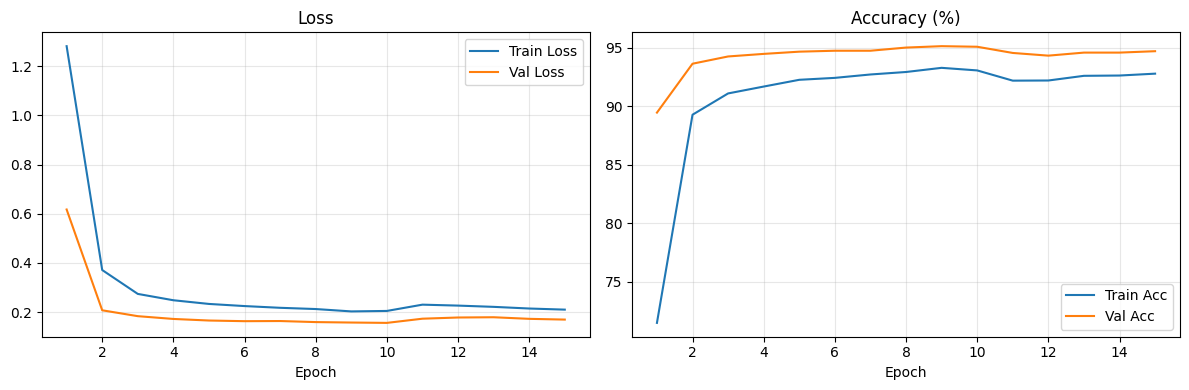


TEST | Loss 0.1591 | Acc 95.01%

Classification Report:
              precision    recall  f1-score   support

    airplane     0.9662    0.9430    0.9545      1000
  automobile     0.9614    0.9710    0.9662      1000
        bird     0.9423    0.9480    0.9452      1000
         cat     0.9172    0.8860    0.9013      1000
        deer     0.9557    0.9490    0.9523      1000
         dog     0.9133    0.9270    0.9201      1000
        frog     0.9720    0.9720    0.9720      1000
       horse     0.9491    0.9700    0.9594      1000
        ship     0.9617    0.9780    0.9698      1000
       truck     0.9618    0.9570    0.9594      1000

    accuracy                         0.9501     10000
   macro avg     0.9501    0.9501    0.9500     10000
weighted avg     0.9501    0.9501    0.9500     10000



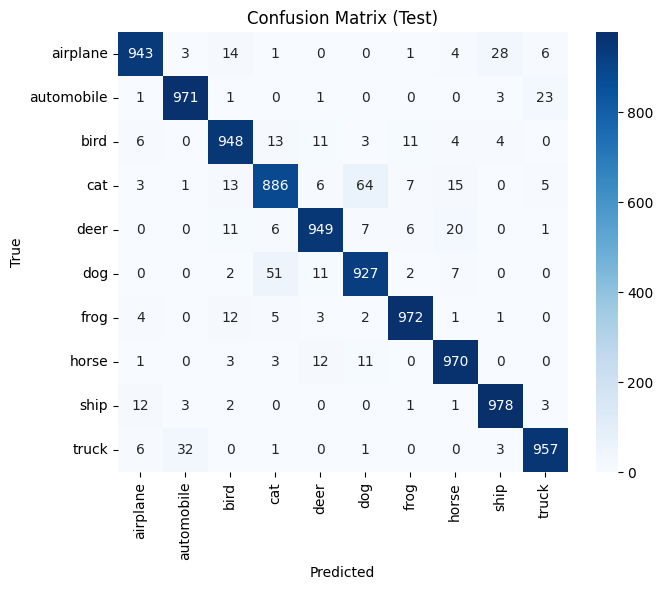


Saved for inference:
 - deit_cifar10_linearprobe_best.ckpt (checkpoint with trained head)
 - deit_cifar10_linearprobe_state.pth (state dict)
 - deit_cifar10_linearprobe_meta.json (classes + preprocessing)


In [2]:
#type 1

 ============================================================
# LINEAR PROBE (head-only): DeiT-Base (timm) on CIFAR-10
# - Load ImageNet-pretrained DeiT-Base
# - Freeze ALL backbone weights
# - Replace & train ONLY the classification head
# - Stratified train/val split, mixed precision, cosine LR, early stopping
# ============================================================

import os, json, random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import transforms, datasets

import timm
from timm.scheduler import CosineLRScheduler

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix

# -------------------- Reproducibility --------------------
SEED = 1337
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True  # speed; set False for strict determinism

# -------------------- Device --------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
amp_enabled = torch.cuda.is_available()
print("Device:", device, "| Mixed precision:", amp_enabled)

# -------------------- Config --------------------
img_size   = 224
batch_size = 128            # can bump batch size since we update only a small head
epochs     = 30
val_ratio  = 0.20
patience   = 5
num_workers = 4 if torch.cuda.is_available() else 2
root = "./data"

# -------------------- Transforms --------------------
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    transforms.RandomErasing(p=0.2)
])

eval_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# -------------------- CIFAR-10 datasets --------------------
full_train = datasets.CIFAR10(root=root, train=True, download=True, transform=train_transform)
test_ds    = datasets.CIFAR10(root=root, train=False, download=True, transform=eval_transform)

class_names = full_train.classes
num_classes = len(class_names)
print("Classes:", class_names, "| num_classes:", num_classes)

# Stratified split indices on CIFAR-10 train
targets = np.array(full_train.targets)
sss = StratifiedShuffleSplit(n_splits=1, test_size=val_ratio, random_state=SEED)
train_idx, val_idx = next(sss.split(np.zeros(len(targets)), targets))

# Build train/val with appropriate transforms
train_ds = datasets.CIFAR10(root=root, train=True, download=False, transform=train_transform)
val_ds   = datasets.CIFAR10(root=root, train=True, download=False, transform=eval_transform)

train_subset = Subset(train_ds, train_idx)
val_subset   = Subset(val_ds,   val_idx)

# -------------------- Loaders --------------------
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=True)
val_loader   = DataLoader(val_subset,   batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True)
test_loader  = DataLoader(test_ds,      batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True)

print(f"Split sizes -> train: {len(train_subset)} | val: {len(val_subset)} | test: {len(test_ds)}")

# -------------------- Model: Linear Probe (freeze backbone) --------------------
# 1) Load ImageNet-pretrained DeiT-Base
model = timm.create_model('deit_base_patch16_224', pretrained=True, num_classes=num_classes)

# 2) Reset classifier to match CIFAR-10 classes (timm takes care of creating a fresh head)
#    If you want to be explicit:
#    in_features = model.get_classifier().in_features
#    model.reset_classifier(num_classes=num_classes)  # creates a new Linear head under the hood

# 3) Freeze ALL params
for p in model.parameters():
    p.requires_grad = False

# 4) Unfreeze ONLY the classifier head params
for p in model.get_classifier().parameters():
    p.requires_grad = True

model = model.to(device)

# Sanity check
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,} | Trainable (head only): {trainable_params:,}")

# -------------------- Optimizer / Loss / Scheduler --------------------
# Only optimize the head
head_params = [p for p in model.get_classifier().parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(head_params, lr=3e-3, weight_decay=0.0)  # higher LR, no WD often works well for linear probe
criterion = nn.CrossEntropyLoss(label_smoothing=0.0)  # usually 0.0 for linear probe, but feel free to try 0.1

lr_scheduler = CosineLRScheduler(
    optimizer,
    t_initial=10,
    lr_min=1e-5,
    warmup_lr_init=1e-4,
    warmup_t=3,
    cycle_limit=3,
)

scaler = torch.cuda.amp.GradScaler(enabled=amp_enabled)

# -------------------- Train / Eval helpers --------------------
def run_epoch(loader, train_mode=True):
    # We keep model in train/eval normally; backbone is frozen so only head updates.
    model.train() if train_mode else model.eval()

    total_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []

    for imgs, labels in loader:
        imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        with torch.cuda.amp.autocast(enabled=amp_enabled):
            outputs = model(imgs)
            loss = criterion(outputs, labels)

        if train_mode:
            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        total_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total   += labels.size(0)

        all_preds.append(preds.detach().cpu().numpy())
        all_labels.append(labels.detach().cpu().numpy())

    avg_loss = total_loss / max(1, total)
    acc = 100.0 * correct / max(1, total)
    all_preds  = np.concatenate(all_preds) if all_preds else np.array([])
    all_labels = np.concatenate(all_labels) if all_labels else np.array([])

    return avg_loss, acc, all_preds, all_labels

# -------------------- Training loop with early stopping --------------------
best_val = float('inf')
best_state = None
best_epoch = -1
wait = 0

train_losses, val_losses, train_accs, val_accs, lrs = [], [], [], [], []

print("Starting linear-probe training (head-only)...")
for epoch in range(1, epochs+1):
    tr_loss, tr_acc, _, _ = run_epoch(train_loader, train_mode=True)

    lr_scheduler.step(epoch)
    current_lr = optimizer.param_groups[0]['lr']

    va_loss, va_acc, _, _ = run_epoch(val_loader, train_mode=False)

    train_losses.append(tr_loss); val_losses.append(va_loss)
    train_accs.append(tr_acc);    val_accs.append(va_acc)
    lrs.append(current_lr)

    print(f"Epoch {epoch:02d}/{epochs} | "
          f"Train Loss {tr_loss:.4f} Acc {tr_acc:.2f}% | "
          f"Val Loss {va_loss:.4f} Acc {va_acc:.2f}% | "
          f"LR {current_lr:.6f}")

    if va_loss < best_val - 1e-4:
        best_val = va_loss
        best_epoch = epoch
        wait = 0
        best_state = {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),     # includes trained head
            "optimizer_state_dict": optimizer.state_dict(),
            "scheduler_state_dict": lr_scheduler.state_dict(),
            "class_names": class_names,
            "img_size": img_size,
            "imagenet_mean": IMAGENET_MEAN,
            "imagenet_std": IMAGENET_STD,
        }
        torch.save(best_state, "deit_cifar10_linearprobe_best.ckpt")
        print("✓ Saved new best checkpoint -> deit_cifar10_linearprobe_best.ckpt")
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered. Restoring best weights from epoch", best_epoch)
            break

# Restore best model before testing
if best_state is not None:
    model.load_state_dict(best_state["model_state_dict"])

# -------------------- Plots --------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
epochs_range = range(1, len(train_losses)+1)
ax1.plot(epochs_range, train_losses, label="Train Loss")
ax1.plot(epochs_range, val_losses,   label="Val Loss")
ax1.set_title("Loss"); ax1.set_xlabel("Epoch"); ax1.legend(); ax1.grid(alpha=0.3)

ax2.plot(epochs_range, train_accs, label="Train Acc")
ax2.plot(epochs_range, val_accs,   label="Val Acc")
ax2.set_title("Accuracy (%)"); ax2.set_xlabel("Epoch"); ax2.legend(); ax2.grid(alpha=0.3)
plt.tight_layout(); plt.show()

# -------------------- Final Test Eval --------------------
test_loss, test_acc, y_pred, y_true = run_epoch(test_loader, train_mode=False)
print(f"\nTEST | Loss {test_loss:.4f} | Acc {test_acc:.2f}%")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Confusion matrix (optional)
try:
    import seaborn as sns
    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=class_names, yticklabels=class_names, cmap="Blues")
    plt.title("Confusion Matrix (Test)"); plt.xlabel("Predicted"); plt.ylabel("True")
    plt.tight_layout(); plt.show()
except Exception as e:
    print("CM plot skipped:", e)

# -------------------- Save minimal inference bundle --------------------
torch.save(model.state_dict(), "deit_cifar10_linearprobe_state.pth")
bundle_meta = {
    "class_names": class_names,
    "img_size": img_size,
    "imagenet_mean": IMAGENET_MEAN,
    "imagenet_std": IMAGENET_STD,
}
with open("deit_cifar10_linearprobe_meta.json", "w") as f:
    json.dump(bundle_meta, f, indent=2)

print("\nSaved for inference:")
print(" - deit_cifar10_linearprobe_best.ckpt (checkpoint with trained head)")
print(" - deit_cifar10_linearprobe_state.pth (state dict)")
print(" - deit_cifar10_linearprobe_meta.json (classes + preprocessing)")


Device: cuda | Mixed precision: True
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] | num_classes: 10


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Split sizes -> train: 40000 | val: 10000 | test: 10000
Total parameters: 85,806,346 | Trainable (type-2 partial): 7,097,098
Starting partial fine-tuning (last block + norm + head)...


/tmp/ipython-input-680396687.py:128: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=amp_enabled)
/tmp/ipython-input-680396687.py:139: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=amp_enabled):


Epoch 01/40 | Train Loss 2.2070 Acc 20.11% | Val Loss 2.0415 Acc 35.16% | LR 0.000011
✓ Saved new best checkpoint -> deit_cifar10_type2_best.ckpt
Epoch 02/40 | Train Loss 1.0367 Acc 82.07% | Val Loss 0.7135 Acc 92.99% | LR 0.000021
✓ Saved new best checkpoint -> deit_cifar10_type2_best.ckpt
Epoch 03/40 | Train Loss 0.7405 Acc 91.19% | Val Loss 0.6563 Acc 94.53% | LR 0.000030
✓ Saved new best checkpoint -> deit_cifar10_type2_best.ckpt
Epoch 04/40 | Train Loss 0.6885 Acc 92.80% | Val Loss 0.6284 Acc 95.37% | LR 0.000040
✓ Saved new best checkpoint -> deit_cifar10_type2_best.ckpt
Epoch 05/40 | Train Loss 0.6597 Acc 93.85% | Val Loss 0.6128 Acc 95.77% | LR 0.000026
✓ Saved new best checkpoint -> deit_cifar10_type2_best.ckpt
Epoch 06/40 | Train Loss 0.6417 Acc 94.52% | Val Loss 0.6055 Acc 96.02% | LR 0.000018
✓ Saved new best checkpoint -> deit_cifar10_type2_best.ckpt
Epoch 07/40 | Train Loss 0.6298 Acc 95.02% | Val Loss 0.6026 Acc 96.04% | LR 0.000011
✓ Saved new best checkpoint -> deit_ci

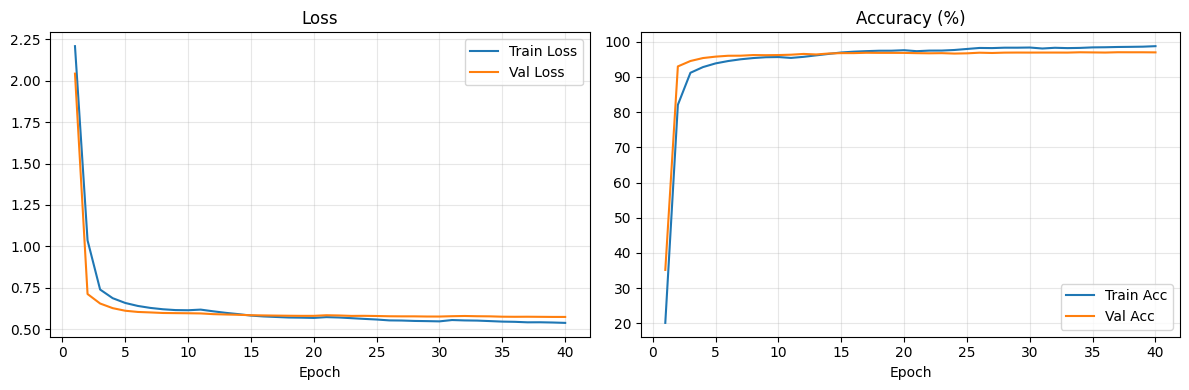


TEST | Loss 0.5778 | Acc 97.15%

Classification Report:
              precision    recall  f1-score   support

    airplane     0.9799    0.9770    0.9785      1000
  automobile     0.9724    0.9880    0.9802      1000
        bird     0.9857    0.9630    0.9742      1000
         cat     0.9366    0.9300    0.9333      1000
        deer     0.9646    0.9820    0.9732      1000
         dog     0.9546    0.9460    0.9503      1000
        frog     0.9782    0.9870    0.9826      1000
       horse     0.9810    0.9820    0.9815      1000
        ship     0.9821    0.9890    0.9856      1000
       truck     0.9798    0.9710    0.9754      1000

    accuracy                         0.9715     10000
   macro avg     0.9715    0.9715    0.9715     10000
weighted avg     0.9715    0.9715    0.9715     10000



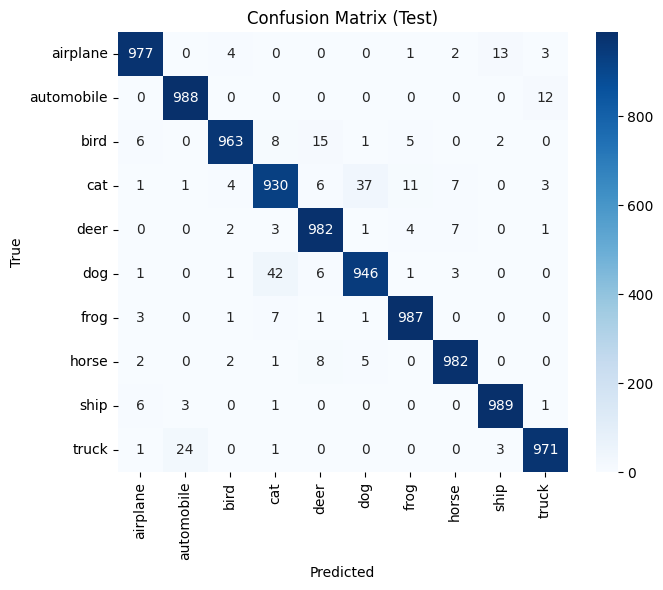


Saved for inference:
 - deit_cifar10_type2_best.ckpt (checkpoint)
 - deit_cifar10_type2_inference_state.pth (state dict)
 - deit_cifar10_type2_inference_meta.json (classes + preprocessing + trainable parts)


In [3]:
# ====== type 2: Partial fine-tune (unfreeze last block/stage only) ======

import os, json, random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import transforms, datasets

import timm
from timm.scheduler import CosineLRScheduler

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix

# -------------------- Reproducibility --------------------
SEED = 1337
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True  # speed

# -------------------- Device --------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
amp_enabled = torch.cuda.is_available()
print("Device:", device, "| Mixed precision:", amp_enabled)

# -------------------- Config --------------------
img_size   = 224
batch_size = 64
epochs     = 40
val_ratio  = 0.20
patience   = 5
num_workers = 4 if torch.cuda.is_available() else 2

# -------------------- Transforms --------------------
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    transforms.RandomErasing(p=0.2)
])

eval_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# -------------------- CIFAR-10 datasets --------------------
root = "./data"
full_train = datasets.CIFAR10(root=root, train=True, download=True, transform=train_transform)
test_ds    = datasets.CIFAR10(root=root, train=False, download=True, transform=eval_transform)

class_names = full_train.classes
num_classes = len(class_names)
print("Classes:", class_names, "| num_classes:", num_classes)

# Stratified split on CIFAR-10 train
targets = np.array(full_train.targets)
sss = StratifiedShuffleSplit(n_splits=1, test_size=val_ratio, random_state=SEED)
train_idx, val_idx = next(sss.split(np.zeros(len(targets)), targets))

train_ds = datasets.CIFAR10(root=root, train=True,  download=False, transform=train_transform)
val_ds   = datasets.CIFAR10(root=root, train=True,  download=False, transform=eval_transform)

train_subset = Subset(train_ds, train_idx)
val_subset   = Subset(val_ds,   val_idx)

# -------------------- Loaders --------------------
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=True)
val_loader   = DataLoader(val_subset,   batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True)
test_loader  = DataLoader(test_ds,      batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True)

print(f"Split sizes -> train: {len(train_subset)} | val: {len(val_subset)} | test: {len(test_ds)}")

# -------------------- Model (partial fine-tune) --------------------
# Create ImageNet-pretrained DeiT-Base with CIFAR-10 head
model = timm.create_model('deit_base_patch16_224', pretrained=True, num_classes=num_classes)

# 1) Freeze EVERYTHING
for p in model.parameters():
    p.requires_grad = False

# 2) Unfreeze the LAST transformer block + final layer norm + classifier head
# timm ViTs expose: model.blocks (ModuleList of 12 blocks), model.norm (LayerNorm), model.head (Linear)
for p in model.blocks[-1].parameters():
    p.requires_grad = True
for p in model.norm.parameters():
    p.requires_grad = True
for p in model.head.parameters():
    p.requires_grad = True

model = model.to(device)

# Quick sanity: count params
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,} | Trainable (type-2 partial): {trainable_params:,}")

# -------------------- Optimizer / Loss / Scheduler --------------------
# Use param groups: slightly lower LR for the last block than the head
param_groups = [
    {"params": model.blocks[-1].parameters(), "lr": 5e-5, "weight_decay": 0.01},
    {"params": model.norm.parameters(),       "lr": 5e-5, "weight_decay": 0.01},
    {"params": model.head.parameters(),       "lr": 1e-4, "weight_decay": 0.01},
]
optimizer = torch.optim.AdamW(param_groups)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

lr_scheduler = CosineLRScheduler(
    optimizer,
    t_initial=10,
    lr_min=1e-6,
    warmup_lr_init=1e-6,
    warmup_t=5,
    cycle_limit=5,
)

scaler = torch.cuda.amp.GradScaler(enabled=amp_enabled)

# -------------------- Train / Eval helpers --------------------
def run_epoch(loader, train_mode=True):
    model.train() if train_mode else model.eval()
    total_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []

    for imgs, labels in loader:
        imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        with torch.cuda.amp.autocast(enabled=amp_enabled):
            outputs = model(imgs)
            loss = criterion(outputs, labels)

        if train_mode:
            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        total_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total   += labels.size(0)

        all_preds.append(preds.detach().cpu().numpy())
        all_labels.append(labels.detach().cpu().numpy())

    avg_loss = total_loss / max(1, total)
    acc = 100.0 * correct / max(1, total)
    all_preds  = np.concatenate(all_preds) if all_preds else np.array([])
    all_labels = np.concatenate(all_labels) if all_labels else np.array([])
    return avg_loss, acc, all_preds, all_labels

# -------------------- Training loop with early stopping --------------------
best_val = float('inf')
best_state = None
best_epoch = -1
wait = 0

train_losses, val_losses, train_accs, val_accs, lrs = [], [], [], [], []

print("Starting partial fine-tuning (last block + norm + head)...")
for epoch in range(1, epochs+1):
    tr_loss, tr_acc, _, _ = run_epoch(train_loader, train_mode=True)
    lr_scheduler.step(epoch)
    current_lr = optimizer.param_groups[0]['lr']  # report first group LR

    va_loss, va_acc, _, _ = run_epoch(val_loader, train_mode=False)

    train_losses.append(tr_loss); val_losses.append(va_loss)
    train_accs.append(tr_acc);    val_accs.append(va_acc)
    lrs.append(current_lr)

    print(f"Epoch {epoch:02d}/{epochs} | "
          f"Train Loss {tr_loss:.4f} Acc {tr_acc:.2f}% | "
          f"Val Loss {va_loss:.4f} Acc {va_acc:.2f}% | "
          f"LR {current_lr:.6f}")

    if va_loss < best_val - 1e-4:
        best_val = va_loss
        best_epoch = epoch
        wait = 0
        best_state = {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "scheduler_state_dict": lr_scheduler.state_dict(),
            "class_names": class_names,
            "img_size": img_size,
            "imagenet_mean": IMAGENET_MEAN,
            "imagenet_std": IMAGENET_STD,
        }
        torch.save(best_state, "deit_cifar10_type2_best.ckpt")
        print("✓ Saved new best checkpoint -> deit_cifar10_type2_best.ckpt")
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered. Restoring best weights from epoch", best_epoch)
            break

# Restore best model
if best_state is not None:
    model.load_state_dict(best_state["model_state_dict"])

# -------------------- Plots --------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
epochs_range = range(1, len(train_losses)+1)
ax1.plot(epochs_range, train_losses, label="Train Loss")
ax1.plot(epochs_range, val_losses,   label="Val Loss")
ax1.set_title("Loss"); ax1.set_xlabel("Epoch"); ax1.legend(); ax1.grid(alpha=0.3)

ax2.plot(epochs_range, train_accs, label="Train Acc")
ax2.plot(epochs_range, val_accs,   label="Val Acc")
ax2.set_title("Accuracy (%)"); ax2.set_xlabel("Epoch"); ax2.legend(); ax2.grid(alpha=0.3)
plt.tight_layout(); plt.show()

# -------------------- Final Test Eval --------------------
test_loss, test_acc, y_pred, y_true = run_epoch(test_loader, train_mode=False)
print(f"\nTEST | Loss {test_loss:.4f} | Acc {test_acc:.2f}%")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Confusion matrix (optional)
try:
    import seaborn as sns
    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=class_names, yticklabels=class_names, cmap="Blues")
    plt.title("Confusion Matrix (Test)"); plt.xlabel("Predicted"); plt.ylabel("True")
    plt.tight_layout(); plt.show()
except Exception as e:
    print("CM plot skipped:", e)

# -------------------- Save minimal inference bundle --------------------
torch.save(model.state_dict(), "deit_cifar10_type2_inference_state.pth")
bundle_meta = {
    "class_names": class_names,
    "img_size": img_size,
    "imagenet_mean": IMAGENET_MEAN,
    "imagenet_std": IMAGENET_STD,
    "trainable_parts": "blocks[-1] + norm + head"
}
with open("deit_cifar10_type2_inference_meta.json", "w") as f:
    json.dump(bundle_meta, f, indent=2)

print("\nSaved for inference:")
print(" - deit_cifar10_type2_best.ckpt (checkpoint)")
print(" - deit_cifar10_type2_inference_state.pth (state dict)")
print(" - deit_cifar10_type2_inference_meta.json (classes + preprocessing + trainable parts)")
